# Keyword extraction from Stack Exchange data

The Stack Exchange Kaggle competition caught my eye because of the  keyword extraction component. I'll use some basic [TF-IDF](http://www.tfidf.com).

TL;DR: __we get close to top scores__ that are verifiably reached without using knowledge of the test data tags, which is the whole point of the competitions.

As training data we get 225K Stack Exchange (SE) posts across 6 categories: [biology](https://biology.stackexchange.com), [cooking](https://cooking.stackexchange.com), [crypto](https://crypto.stackexchange.com), [diy](https://diy.stackexchange.com), [robotics](https://robotics.stackexchange.com) and [travel](https://travel.stackexchange.com). These posts have tags, manually assigned by their authors, which are included in the dataset.

![All-subjects illustration: biology, coooking/seasoned advice, cryptography, travel, robotics beta, home improvement](../notebooks-img/subjects.png?raw=True "All-subjects illustration: biology, coooking/seasoned advice, cryptography, travel, robotics beta, home improvement")



The challenge is to generate labels for posts in a 7th category - [physics](https://physics.stackexchange.com) - for which we don't have tags. We therefore need to learn how to extract keywords as optimally as possible.

See [the Kaggle Stack Exchange competition webiste](https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags) for full details and for the data!

---

In [29]:
from __future__ import print_function
import zipfile
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import os, sys
from six.moves import cPickle as pickle
import time
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import expon, uniform, randint
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

## Data exploration and processing

After importing libraries, we load the data to dataframes.

In [ ]:
def getCSVData():
    
    all_subjects = ["biology", "cooking", "crypto", "diy", "robotics", "travel"]
    subjects_dfs = {}
    
    for subject in all_subjects:
        
        csv_filename = subject + ".csv"        
        subject_df = pd.read_csv(csv_filename)
        print("read", subject, "data with shape", subject_df.shape)
        subjects_dfs[subject] = subject_df
        
    return subjects_dfs

In [165]:
subjects_dfs = getCSVData()

read biology data with shape (13196, 4)
read cooking data with shape (15404, 4)
read crypto data with shape (10432, 4)
read diy data with shape (25918, 4)
read robotics data with shape (2771, 4)
read travel data with shape (19279, 4)


We can take a look at some rows from each subject's dataframe:

In [166]:
for subject in subjects_dfs.keys():
    print(subject)
    display(subjects_dfs[subject][:5])

biology


,id,title,content,tags
0,1,What is the criticality of the ribosome bindin...,"<p>In prokaryotic translation, how critical fo...",ribosome binding-sites translation synthetic-b...
1,2,How is RNAse contamination in RNA based experi...,<p>Does anyone have any suggestions to prevent...,rna biochemistry
2,3,Are lymphocyte sizes clustered in two groups?,<p>Tortora writes in <em>Principles of Anatomy...,immunology cell-biology hematology
3,4,How long does antibiotic-dosed LB maintain goo...,<p>Various people in our lab will prepare a li...,cell-culture
4,5,Is exon order always preserved in splicing?,<p>Are there any cases in which the splicing m...,splicing mrna spliceosome introns exons


cooking


,id,title,content,tags
0,1,How can I get chewy chocolate chip cookies?,<p>My chocolate chips cookies are always too c...,baking cookies texture
1,2,How should I cook bacon in an oven?,<p>I've heard of people cooking bacon in an ov...,oven cooking-time bacon
2,3,What is the difference between white and brown...,"<p>I always use brown extra large eggs, but I ...",eggs
3,4,What is the difference between baking soda and...,<p>And can I use one in place of the other in ...,substitutions please-remove-this-tag baking-so...
4,5,"In a tomato sauce recipe, how can I cut the ac...",<p>It seems that every time I make a tomato sa...,sauce pasta tomatoes italian-cuisine


travel


,id,title,content,tags
0,1,What are some Caribbean cruises for October?,<p>My fiancée and I are looking for a good Car...,caribbean cruising vacations
1,2,How can I find a guide that will take me safel...,"<p>This was one of our definition questions, b...",guides extreme-tourism amazon-river amazon-jungle
2,4,Does Singapore Airlines offer any reward seats...,<p>Singapore Airlines has an all-business clas...,loyalty-programs routes ewr singapore-airlines...
3,5,What is the easiest transportation to use thro...,<p>Another definition question that interested...,romania transportation
4,6,How can I visit Antarctica?,"<p>A year ago I was reading some magazine, and...",extreme-tourism antarctica


robotics


,id,title,content,tags
0,1,What is the right approach to write the spin c...,<p>Imagine programming a 3 wheel soccer robot....,soccer control
1,2,How can I modify a low cost hobby servo to run...,"<p>I've got some hobby servos (<a href=""http:/...",control rcservo
2,3,What useful gaits exist for a six legged robot...,"<p><a href=""http://www.oricomtech.com/projects...",gait walk
3,4,Good Microcontrollers/SOCs for a Robotics Project,<p>I am looking for a starting point for my pr...,microcontroller arduino raspberry-pi
4,5,Nearest-neighbor data structure for non-Euclid...,<p>I'm trying to implement a nearest-neighbor ...,motion-planning rrt


crypto


,id,title,content,tags
0,3,What are the benefits of the two permutation t...,<p>Why do we use a permutation table in the fi...,block-cipher des permutation
1,7,Why use a 1-2 Oblivious Transfer instead of a ...,"<p>When initiating an <a href=""http://en.wikip...",oblivious-transfer multiparty-computation func...
2,8,Why do we append the length of the message in ...,"<p>As we know, <a href=""http://en.wikipedia.or...",sha-1 hash
3,9,What is the general justification for the hard...,<p>Since most cryptographic hash functions are...,hash cryptanalysis preimage-resistance
4,14,"How can I use asymmetric encryption, such as R...",<p>RSA is not designed to be used on long bloc...,encryption rsa public-key


diy


,id,title,content,tags
0,1,"How do I install a new, non load bearing wall ...",<p>I'm looking to finish my basement and simpl...,remodeling basement carpentry
1,2,What kind of caulk should I use around my bath...,<p>I would like to recaulk between the bathtub...,caulking bathroom
2,3,Is fiberglass mesh tape a good choice for dryw...,<p>I'm going to be doing some drywalling short...,drywall
3,4,Are there ways to determine if a wall is load ...,"<p>Other than looking up blue prints, which ma...",walls load-bearing structural
4,5,How do I safely replace a worn out electrical ...,<p>I have a number of outlets that are old and...,repair electrical


In order to make the steps forward a bit easier, we can remove the newlines and the html tags in the ``content`` and ``title`` fields.

In [14]:
for subject in subjects_dfs.keys():

    for index, row in subjects_dfs[subject].iterrows():

        # remove tags and newlines
        clean_content = BeautifulSoup(str(row['content']).decode('utf-8','ignore'), "html.parser")
        clean_content = "".join(clean_content.findAll(text=True)).replace("\n", "")

        clean_title = BeautifulSoup(str(row['title']).decode('utf-8','ignore'), "html.parser")
        clean_title = "".join(clean_title.findAll(text=True)).replace("\n", "")

        subjects_dfs[subject].set_value(index, "content", clean_content)
        subjects_dfs[subject].set_value(index, "title", clean_title)

### Title vs/+ content

Assuming that more data will be better (which may or may not be true for this problem), we'll use the title and content text as our training data. 

People in kernels or discussions on the Kaggle website have successfully only used the title. My compromise is that I'll only take certain number of characters. Below we can see a rough distribution of the character count for each subject on titles and content:

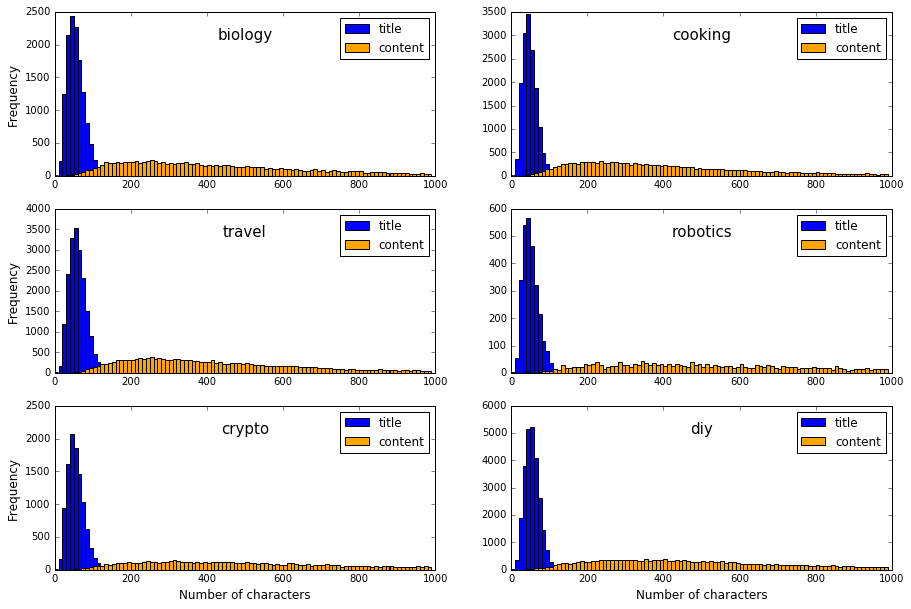

In [22]:
plt.figure(figsize=(15, 10))

for i, subject in enumerate(subjects_dfs.keys()):
    
    plt.subplot(321+i)
    plt.legend()
    if i>3:
        plt.xlabel('Number of characters', fontsize=12)
    if i%2 == 0:
        plt.ylabel('Frequency', fontsize=12)
    plt.hist(subjects_dfs[subject].title.apply(len), bins=xrange(0,1000,10), label='title')
    plt.hist(subjects_dfs[subject].content.apply(len), bins=xrange(0,1000,10), label='content', color='orange')
    plt.legend()
    plt.title(subject, y=0.8, fontsize=15)

plt.show() 

We'll encompass most complete questions taking 500 characters. For questions above that length, the first 400 characters of the content and the last 100 are taken. This comes from an educated guess that most of the salient, high-level content of a question is expressed at the beginning or the end of a post.

In [ ]:
for subject in subjects_dfs.keys():

    for index, row in subjects_dfs[subject].iterrows():

        # trim content
        content = row['content']
        if len(content) > 500:
            content = content[:400] + " " + content[-100:]

        subjects_dfs[subject].set_value(index, "content", content)

## Corpus for TFIDF

Another decision is whether to do TFIDF over the entire corpus of all 6 disciplines or to make each discipline its own corpus. I chose the latter. It seems logical that a post's author already chose a specific SE website to give some context to their question. Tags are then chosen with that context in mind. Since keyword extraction for each post will consist of taking the top TFIDF terms, the terms we extract should be be distinctive within the subject, not necessarily within the whole SE universe.

## TFIDF parameters

From here we do a random search of the TFIDF parameters. This is what we'll be learning and then applying to the test data: a set of parameters that give us the best tag predictions.

### max_features

To decide the random search range for the ``max_features`` parameter (which builds "a vocabulary that only consider the top max_features ordered by term frequency across the corpus") we look at how many of the most common tags we need to apply to reach 90% of all the tag applications for each subject.

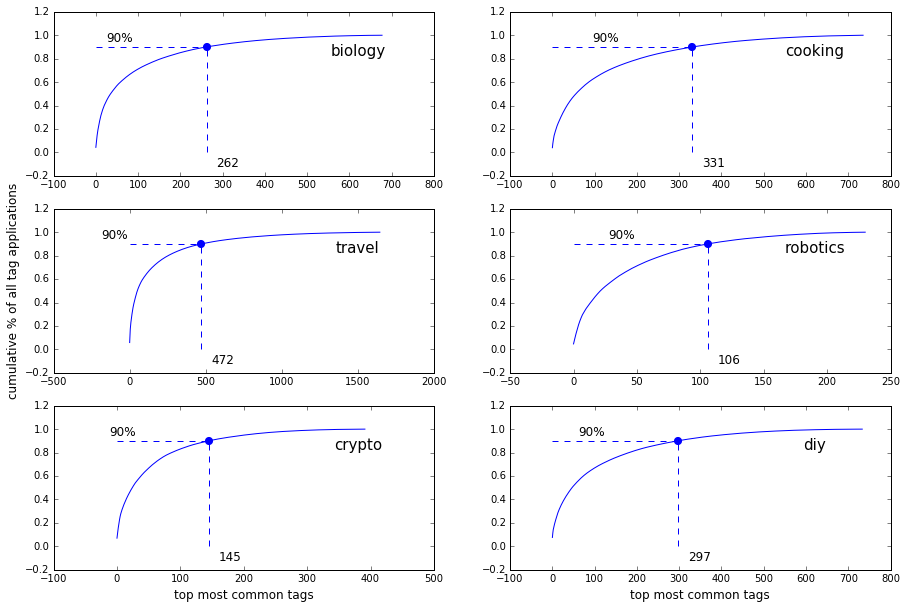

In [9]:
plt.close()
plt.figure(figsize=(15, 10))

for i, subject in enumerate(subjects_dfs.keys()):
    
    # plot
    plt.subplot(321+i)
    if i>3:
        plt.xlabel('top most common tags', fontsize=12)
    if i==2:
        plt.ylabel('cumulative % of all tag applications', fontsize=12)
    
    
    # collect all tags and count all tag tokens and types
    all_tags = [tag for tags in subjects_dfs[subject].tags for tag in tags.split()]
    c = Counter(all_tags) # count by type
    num_tag_tokens = float(len(all_tags)) # count all tokens
    
    # token cumulative sum over most common types
    token_cum_sum = np.cumsum([count for _, count in c.most_common()])
    
    # number of type that goes over 90% in token cumulative sum over most common types
    ninety_percent_type = next(i for i,v in enumerate(token_cum_sum) if v > num_tag_tokens*0.9)

    # cumulative proportion of tokens by most common tags
    plt.plot(token_cum_sum/num_tag_tokens)
    
    # 90% dot
    approx_90 = token_cum_sum[ninety_percent_type]/num_tag_tokens
    plt.scatter([ninety_percent_type, ], [approx_90, ], 50, color='blue')
    
    # lines to 90% dot
    plt.plot([ninety_percent_type, ninety_percent_type], [0, approx_90], color='blue', linestyle="--")    
    plt.plot([0, ninety_percent_type], [approx_90, approx_90], color='blue', linestyle="--")    
    
    # annotations
    plt.annotate(ninety_percent_type,
            xy=(ninety_percent_type, approx_90), xycoords='data',
            xytext=(+10, -120), textcoords='offset points', fontsize=12)
    plt.annotate(r"90%",
            xy=(ninety_percent_type, approx_90), xycoords='data',
            xytext=(-100, +5), textcoords='offset points', fontsize=12)
    
    plt.title(subject, y=0.7, x=0.8, fontsize=15)

plt.show()
    

From the data above I conclude that lower values - down to even ~100 - for the max_features limit should be explored. For the robotics category we need just over 100 tag types to get us just above 90% of the label applications, while for the travel category 472 tag types are required.

### Number of tags

Another determination to make is how many tags to extract. Again, we can look at the data to see how many tags are usually assigned to posts per discipline:

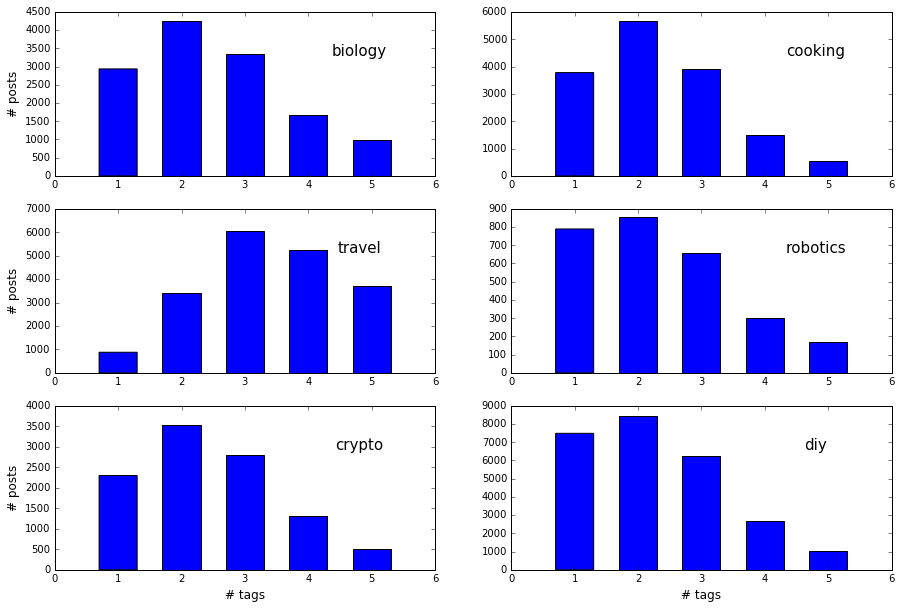

In [10]:
plt.close()
plt.figure(figsize=(15, 10))

for i, subject in enumerate(subjects_dfs.keys()):
    
    # plot
    plt.subplot(321+i)
    if i>3:
        plt.xlabel('# tags', fontsize=12)
    if i%2==0:
        plt.ylabel('# posts', fontsize=12)
    
    tag_num = np.array([len(tags.split()) for tags in subjects_dfs[subject].tags])

    # assign proper bins, roughly from http://stackoverflow.com/a/30121210/583834
    bins = [(b-0.3, b+0.3) for b in np.unique(tag_num)]
    bins = [b for vals in bins for b in vals]
    plt.hist(tag_num, bins)
    
    plt.title(subject, y=0.7, x=0.8, fontsize=15)
    
plt.show()

It seems like the data only has up to 5 tags, so we'll extract the top 5 TFIDF terms per post.

### Scoring

Below we define some metrics for tag extraction. We want to assess

1. precision: proportion of extracted terms that were actual tags
2. recall: from the actual tags, the proportion that were predicted in the top 5 extracted terms
3. a balanced f-score, used to evaluate the Kaggle competition, defined as in the [``sklearn.metrics``](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) package: F1 = 2 * (precision * recall) / (precision + recall)

In [10]:
def scores(extracted, actual):
    actual_tags = actual.split()
    extracted_tags = extracted.split()
    
    # precision
    prec_counter = 0
    for et in extracted_tags:
        if et in actual_tags:
            prec_counter += 1
        
    precision = prec_counter/float(5)
        
    # recall
    recall_counter = 0
    for at in actual_tags:
        if at in extracted_tags:
            recall_counter += 1
    
    recall = recall_counter/float(len(actual_tags))
    
    # f-score
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    return precision, recall, f1

Now we learn the TFIDF terms within each subject. We do this with the [``TfidfVectorizer``](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) function, for which we need to find optimal parameters. ``TfidfVectorizer`` is nice because it takes care of tokenization and counting, which [``CountVectorizer``](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) usually takes care of, as well as of TFIDF transformation, which [``TfidfTransformer``](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) normally performs.

## Random search over TFIDF parameters

We use random search over parameters because, as [Bergstra and Bengio](http://www.jmlr.org/papers/v13/bergstra12a.html) [\[pdf\]](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) point out, compared to grid search, "random search over the same domain is able to find models that are as good or better within a small fraction of the computation time." This image, from Bergstra and Bengio's paper, is a nice illustration of the advantages of random search over grid search: 

![Random Search vs. Grid Search](../notebooks-img/bergstra_bengio_grid_vs_random.png?raw=True "Random Search vs. Grid Search")

In the end, we'll pick the set of parameters with the best scores and extract TFIDF terms from the test data. (Keeping in mind that they may not be very high without knowing more about the labels in the test set, according to [the](https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags/discussion/29245) [disc](https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags/discussion/27607)[ussions](https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags/discussion/32011) and the [leaderboard](https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags/leaderboard) in the Kaggle competition.)

The code below iterates over a list of random parameters. For every set of random parameters, we learn the TFIDF terms for every subject and then compare the top 5 TFIDF terms per post to their tags. We'll use accuracy, recall and f-score, as defined above.

In [6]:
n_iter = 60

stop_words = [np.random.choice(['english', None]) for _ in xrange(n_iter)]
binary = [np.random.choice([True, False]) for _ in xrange(n_iter)]
sublinear_tf = [np.random.choice([True, False]) for _ in xrange(n_iter)]
n_gram = [(1,n) for n in [np.random.choice([2, 3, 4]) for _ in xrange(n_iter)]]
# exponential distribution. sample count: Counter({1: 62, 2: 27, 4: 6, 3: 5})
min_df = np.ceil(expon.rvs(scale=1.05, size=n_iter)).astype(int) 
# uniform distribution in [0.5, 1]
max_df = uniform.rvs(loc=0.5, scale=0.5, size=n_iter) 

# mix in None for no limits on the number of features
max_features = np.append(randint.rvs(low=1, high=50, size=n_iter-30)*100, [None]*30)

# verify that the minimum value is around 100-200
np.random.shuffle(max_features)
print("min max_features term (should be 100 or 200):", min([x for x in max_features if x is not None]))

random_search_list = [(i, stop_words[i], binary[i], sublinear_tf[i], n_gram[i], 
                       min_df[i], max_df[i], max_features[i]) for i in xrange(n_iter)]

for i, stop_words, binary, sublinear_tf, n_gram, min_df, max_df, max_features in random_search_list:
    
    precision_acc = []
    recall_acc = []
    f1_acc = []
    
    start_time = time.time()    

    for subject in subjects_dfs.keys():
        
        print(subject, end="...")

        data = list(subjects_dfs[subject].title + " " + subjects_dfs[subject].content)
        
        # TFIDF extraction
        tfidf_vect = TfidfVectorizer(stop_words=stop_words, binary=binary, 
                                     sublinear_tf=sublinear_tf, ngram_range=n_gram, 
                                     min_df=min_df, max_df=max_df, max_features=max_features)
        tfidf_data = tfidf_vect.fit_transform(data)
        
        indices = np.argsort(tfidf_vect.idf_)[::-1]
        features = tfidf_vect.get_feature_names()
        
        top_n = 5
        
        # for every document, extract top_n most important terms
        for index in xrange(tfidf_data.shape[0]):
            row = tfidf_data[index].toarray()[0]
            top_n_keywords_indices = np.argsort(row)[::-1][:top_n]
            top_n_keywords = [features[i].encode('utf-8').replace(" ", "-") for i in top_n_keywords_indices]
            extracted_tags = " ".join(top_n_keywords)
            actual_tags = subjects_dfs[subject].iloc[index].tags
            
            # get scores
            precision, recall, f1 = scores(extracted_tags, actual_tags)
            
            # add scores to accumulators
            precision_acc.append(precision)
            recall_acc.append(recall)
            f1_acc.append(f1)
            
    print()
    print("precision mean =", np.mean(precision_acc))
    print("recall mean =", np.mean(recall_acc))
    print("f1 mean =", np.mean(f1_acc), end=" | ")
    
    print("stop_words", stop_words, end=" | ")
    print("binary", binary, end=" | ")
    print("sublinear_tf", sublinear_tf, end=" | ")
    print("n_gram", n_gram, end=" | ")
    print("min_df", min_df, end=" | ")
    print("max_df", max_df, end=" | ")
    print("max_features", max_features, end="\n"*2)
    
    
    print(time.time()-start_time, "sec to explore these parameters", end="\n"*3)    

min max_features term (should be 100 or 200): 200
biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.0814390804598
recall mean = 0.169317624521
f1 mean = 0.104697117314 | stop_words english | binary False | sublinear_tf False | n_gram (1, 2) | min_df 1 | max_df 0.922986658074 | max_features None

846.458415031 sec to explore these parameters


biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.0976574712644
recall mean = 0.205904789272
f1 mean = 0.126191096515 | stop_words None | binary False | sublinear_tf True | n_gram (1, 4) | min_df 2 | max_df 0.59415012069 | max_features 2500

156.708649874 sec to explore these parameters


biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.0171471264368
recall mean = 0.035562835249
f1 mean = 0.0219921364714 | stop_words None | binary True | sublinear_tf True | n_gram (1, 3) | min_df 1 | max_df 0.70478917668 | max_features 3400

107.329071999 sec to explore these parameters




biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.0305977011494
recall mean = 0.0629208812261
f1 mean = 0.0391353037767 | stop_words english | binary True | sublinear_tf False | n_gram (1, 2) | min_df 1 | max_df 0.81469760494 | max_features 4100

60.1529998779 sec to explore these parameters


biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.0747287356322
recall mean = 0.158078927203
f1 mean = 0.0966625342091 | stop_words None | binary False | sublinear_tf False | n_gram (1, 2) | min_df 1 | max_df 0.693945609465 | max_features 500

59.4528679848 sec to explore these parameters


biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.0633126436782
recall mean = 0.131719348659
f1 mean = 0.0813709177157 | stop_words english | binary False | sublinear_tf True | n_gram (1, 4) | min_df 2 | max_df 0.703557732871 | max_features None

259.821424007 sec to explore these parameters


biology...cooking...travel...robotics...cry

biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.0347379310345
recall mean = 0.0716781609195
f1 mean = 0.0444729520161 | stop_words english | binary True | sublinear_tf True | n_gram (1, 4) | min_df 1 | max_df 0.527204984837 | max_features 3100

109.295218945 sec to explore these parameters


biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.00881149425287
recall mean = 0.0180377394636
f1 mean = 0.0112415800036 | stop_words english | binary True | sublinear_tf False | n_gram (1, 2) | min_df 4 | max_df 0.843339090251 | max_features None

92.0651040077 sec to explore these parameters


biology...cooking...travel...robotics...crypto...diy...
precision mean = 0.00083908045977
recall mean = 0.0016714559387
f1 mean = 0.00106016237913 | stop_words None | binary True | sublinear_tf False | n_gram (1, 2) | min_df 2 | max_df 0.90428049147 | max_features None

245.600418091 sec to explore these parameters


biology...cooking...travel...robotics..

## Optimal parameters

Below we can see which parameter choices correlate to a higher f-score. The scores below were sorted from the output above with [Sublime Text](https://www.sublimetext.com):

    f1 mean = 0.15080534574 | stop_words english | binary False | sublinear_tf False | n_gram (1, 4) | min_df 1 | max_df 0.896748425386 | max_features 1800
    f1 mean = 0.15010764459 | stop_words english | binary False | sublinear_tf False | n_gram (1, 4) | min_df 2 | max_df 0.776479120831 | max_features 3700
    f1 mean = 0.150000693304 | stop_words english | binary False | sublinear_tf False | n_gram (1, 3) | min_df 2 | max_df 0.744628290302 | max_features 3700
    f1 mean = 0.149985951469 | stop_words english | binary False | sublinear_tf False | n_gram (1, 4) | min_df 1 | max_df 0.812935607291 | max_features 1600
    f1 mean = 0.148706887429 | stop_words english | binary False | sublinear_tf False | n_gram (1, 4) | min_df 2 | max_df 0.949335894647 | max_features 4300

So we have:

In [146]:
stop_words = "english" 
binary = False
sublinear_tf = False
n_gram = (1, 4) 
min_df = 1 
max_df = 0.896748425386
max_features = 1800

## Optimal parameters on the training data

Given these parameters, we can see what the top 5 terms are for a random selection of 10 posts in every subject.

In [215]:
def extractTopNTermsFromPosts(tfidf_vect, tfidf_data, data_df, top_n=5):
    
    indices = np.argsort(tfidf_vect.idf_)[::-1]
    features = tfidf_vect.get_feature_names()

    data_size = tfidf_data.shape[0]

    start_time = time.time()

    for index in xrange(data_size):

        row = tfidf_data[index].toarray()[0]
        top_n_keywords_indices = np.argsort(row)[::-1][:top_n]
        top_n_keywords = [features[i].encode('utf-8').replace(" ", "-") for i in top_n_keywords_indices]
        predictions = " ".join(top_n_keywords)
        data_df.set_value(index, "extracted_tags", predictions)

    print(time.time()-start_time, "sec to generate tags for", data_size, "post extracts", end="\n"*3)

In [216]:
for subject in subjects_dfs.keys():
        
    print(subject, end="\n"*2)

    data = list(subjects_dfs[subject].title + " " + subjects_dfs[subject].content)
    
    start_time = time.time()

    tfidf_vect = TfidfVectorizer(stop_words=stop_words, binary=binary, 
                                 sublinear_tf=sublinear_tf, ngram_range=n_gram, 
                                 min_df=min_df, max_df=max_df, max_features=max_features)
    tfidf_data = tfidf_vect.fit_transform(data)
    
    print(time.time()-start_time, "sec to learn", subject, "TFIDF terms")

    extractTopNTermsFromPosts(tfidf_vect, tfidf_data, subjects_dfs[subject])

biology

19.2907319069 sec to learn biology TFIDF terms
3.18287205696 sec to generate tags for 13196 post extracts


cooking

17.5198159218 sec to learn cooking TFIDF terms
3.65562391281 sec to generate tags for 15404 post extracts


travel

24.3508980274 sec to learn travel TFIDF terms
4.89198493958 sec to generate tags for 19279 post extracts


robotics

6.10756611824 sec to learn robotics TFIDF terms
0.678650140762 sec to generate tags for 2771 post extracts


crypto

20.2420361042 sec to learn crypto TFIDF terms
2.57809400558 sec to generate tags for 10432 post extracts


diy

41.3277900219 sec to learn diy TFIDF terms
6.32636904716 sec to generate tags for 25918 post extracts




### Biology predicted tags

![Biology site logo](../notebooks-img/biology.png?raw=True "Biology site logo")

In [156]:
def displayContenTags(data_df, size=5, test=False):
    indices = np.random.choice(data_df.shape[0], size=size, replace=False)
    for index in indices:
        print("Post ID:", index)
        print("Title:", data_df.loc[index].title, end="\n"*2)
        print("Content:", data_df.loc[index].content, end="\n"*2)
        if not test:
            print("Actual Tags:", data_df.loc[index].tags)
        print("Pred.  Tags:", data_df.loc[index].extracted_tags, end="\n\n---\n")

In [144]:
displayContenTags(subjects_dfs["biology"])

Post ID: 11731
Title: Why does meiotic recombination disrupt the independent assortment of genes on the same chromosome?

Content: There are many sources that say that genes that are "linked" by being on the same chromosome assort with each other -- that when an allele is passed on that the gamete containing said allele will also contain every allele from the chromosome rather than simple allowing everything to assort independently.There are also many sources that say during meiosis there is recombination, hence, why aren't all genes completely random?

Actual Tags: genetics chromosome meiosis recombination allele
Pred.  Tags: allele chromosome recombination genes sources

---
Post ID: 5349
Title: Why ml scale blood retrieval is required to run a blood test?

Content: Substances found in blood are present at microscopic scale and tend to be invisible to the unaided eye. Why is a whole vial of blood (at ml scale) is required to assess the presence and concentration of substances, given 

### Cooking predicted tags

![Cooking site logo](../notebooks-img/cooking.png?raw=True "Cooking site logo")

In [100]:
displayContenTags(subjects_dfs["cooking"])

Post ID: 10194
Title: Is there no use for high temperatures in ovens?

Content: I'm about to buy a new oven. I can buy one which is able to steam the food, or one without.The one with steam (a nice, but not necessary feature) only goes to 230 °C / 446 °F, while a regular one to 275 °C / 527 °F.The salesman claimed that no one needs anything higher than the 446 °F, but I've used higher temperatures many times; pizza, roasting meat, etc.Have I used too high temperatures before? Or was he just uninformed?

Actual Tags: temperature oven
Pred.  Tags: temperatures higher steam high buy

---
Post ID: 3380
Title: Undercooked beans in chili?

Content: I made a bit of a mistake, being a lazy bachelor and inexperienced at cooking.  I was making chili and when it came time to add beans I discovered I didn't have any canned beans.  I did however have some dried beans.  I decided to save time and add these directly to the pot of chili and add some water.However, after much simmering the beans mainta

### Travel predicted tags

![Travel site logo](../notebooks-img/travel.png?raw=True "Travel site logo")

In [101]:
displayContenTags(subjects_dfs["travel"])

Post ID: 13565
Title: How do I renew a visa to enter the US from Bolivia?

Content: What document is necessary for a Bolivian national currently in Bolivia to renew a visa for travel to the US?

Actual Tags: visas bolivia
Pred.  Tags: renew visa-enter visa-travel document necessary

---
Post ID: 13144
Title: Fingerprint Process in Poland

Content: Are there Fingerprint taking processes in Polish airports for Schengen Visa Holders at the time of entry to the country?

Actual Tags: poland
Pred.  Tags: polish holders poland airports process

---
Post ID: 3718
Title: Credit Card travel insurance length

Content: Many credit cards offer free travel insurance when you purchase tickets using your credit card, and this will last for 40 days starting from the commencement of your trip.But what if I purchase further flights and extend my holiday?  e.g. I purchase a flight on the 39th day. Does this extend my travel insurance coverage or start a new insurance policy?What if I purchase flights on 

### Robotics predicted tags

![Robotics site logo](../notebooks-img/robotics.png?raw=True "Robotics site logo")

In [105]:
displayContenTags(subjects_dfs["robotics"])

Post ID: 2196
Title: imu position without GPS or camera

Content: I have a IMU that has 3-axis accelerator, 3-axis magnetometer, 3-axis gyroscope and row, yaw, pitch value. I want to get the location of the IMU coordinate(the beginning point is (0,0,0)) but I know just using double integration will has dead reckoning problem. And I found a lot of paper just talking about combining IMU with GPS or camera by using Kalman filter. Is it possible that I just use a IM Because in the future work I will use multiple IMUs bounded on human arms to increase the accuracy. 

Actual Tags: imu gps
Pred.  Tags: imu axis just gps camera

---
Post ID: 499
Title: Polling or Timer interrupt?

Content: We hope to build a simple line follower robot and we got a problem when we were discussing about PIC programming.We planed to write a endless loop, check the sensor panel reading and do the relevant stuff for that reading.But one of our friends told us to use a timer interrupt to generate interrupts in defin

### Crypto predicted tags

![Cryptography site logo](../notebooks-img/crypto.png?raw=True "Cryptography site logo")

In [107]:
displayContenTags(subjects_dfs["crypto"])

Post ID: 9905
Title: "NP-complete" authentication systems

Content: Are there any symmetric authentication systems based on the hardness of an NP-complete problem? I understand that it doesn't really matter, since NP-completeness is about the worst case, and in crypto we care about the average case, but I still feel it's somewhat interesting...

Actual Tags: authentication
Pred.  Tags: np complete systems authentication case

---
Post ID: 1025
Title: Is there a way to make RC4 (ARCFOUR) secure, or is it completely broken?

Content: I need a method to authenticate a process with another in order to establish interprocess communication between them, to prevent malicious processes from trying to hook onto the system. Currently I just send a password in plaintext between the two processes and the host process just performs a string comparison with its copy of the password, and will disconnect the connecting process if they don't re than twice that amount if SHA-256 is used. I am going to h

### DIY/Home Improvement predicted tags

![Home Improvement site logo](../notebooks-img/diy.png?raw=True "Home Improvement site logo")

In [109]:
displayContenTags(subjects_dfs["diy"])

Post ID: 14259
Title: How do you replace existing wires behind walls

Content: Existing wiring installed in walls. May or may not be stapled. Some of it is stapled with newer plastic staples, older runs with metal staples. I've had varied success with this by twisting and taping the new wire to the old wire together and pulling it through but in cases where there are staples, bends or tight spaces I've had the connection break. Wondering how exactly others accomplish this.In hin enough to pass through existing fasteners or strong enough to pop out fasteners by yanking hard?

Actual Tags: wiring
Pred.  Tags: existing walls wire pop pass

---
Post ID: 4579
Title: how to fix jammed integrated dishwasher door?

Content: It seems something has happened to my dishwasher so I can now only open the door halfway, before it starts jamming. The wooden facia on the front of the door is unaligned by a centimeter or two, meaning the facia jams against the surrounding cupboard unitsIf I peek through 

## Test data evaluation

![Physics site logo](../notebooks-img/physics.png?raw=True "Physics site logo")

### Preprocessing
    
We now turn toward test data. We first process it as we did with the training data:

In [203]:
test_df = pd.read_csv("test.csv")
display(test_df[:10])

start_time = time.time()

for index, row in test_df.iterrows():
    # remove tags and newlines + trim content
    clean_title = BeautifulSoup(str(row['title']).decode('utf-8','ignore'), "html.parser")
    clean_title = "".join(clean_title.findAll(text=True)).replace("\n", "")
    
    clean_content = BeautifulSoup(str(row['content']).decode('utf-8','ignore'), "html.parser")
    clean_content = "".join(clean_content.findAll(text=True)).replace("\n", "")
    
    if len(clean_content) > 500:
        clean_content = clean_content[:400] + " " + clean_content[-100:]

    test_df.set_value(index, "content", clean_content)
    test_df.set_value(index, "title", clean_title)
    
print(time.time()-start_time, "sec to preprocess test data")

,id,title,content
0,1,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...
1,2,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...
2,3,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...
3,7,Will Determinism be ever possible?,<p>What are the main problems that we need to ...
4,9,Hamilton's Principle,<p>Hamilton's principle states that a dynamic ...
5,13,What is sound and how is it produced?,"<p>I've been using the term ""sound"" all my lif..."
6,15,What experiment would disprove string theory?,<p>I know that there's big controversy between...
7,17,Why does the sky change color? Why the sky is ...,<p>Why does the sky change color? Why the sky ...
8,19,How's the energy of particle collisions calcul...,<p>Physicists often refer to the energy of col...
9,21,Monte Carlo use,<p>Where is the Monte Carlo method used in phy...


59.1584689617 sec to preprocess test data


### Extracting keywords with TFIDF

Now, we use these best parameters learnt with the random search to extract TFIDF terms in the test data:

In [217]:
test_data = list(test_df.title + " " + test_df.content)

# TFIDF extraction
start_time = time.time()

tfidf_vect = TfidfVectorizer(stop_words=stop_words, binary=binary, 
                             sublinear_tf=sublinear_tf, ngram_range=n_gram, 
                             min_df=min_df, max_df=max_df, max_features=max_features)
tfidf_data = tfidf_vect.fit_transform(test_data)

print(time.time()-start_time, "sec to learn test data TFIDF terms")

82.7040011883 sec to learn test data TFIDF terms


In [218]:
extractTopNTermsFromPosts(tfidf_vect, tfidf_data, test_df)

20.4767808914 sec to generate tags for 81926 post extracts




Below we can see small extracts of the first 10  posts and their extracted tags.

In [171]:
display(test_df[:10])

,id,title,content,extracted_tags
0,1,What is spin as it relates to subatomic partic...,I often hear about subatomic particles having ...,spin spinning particles hear relate
1,2,What is your simplest explanation of the strin...,How would you explain string theory to non phy...,string-theory string theory physicists needed
2,3,"Lie theory, Representations and particle physics",This is a question that has been posted at man...,acting group lie representations vector
3,7,Will Determinism be ever possible?,What are the main problems that we need to sol...,uncertainty-principle main uncertainty problem...
4,9,Hamilton's Principle,Hamilton's principle states that a dynamic sys...,principle stationary action integral minimum
5,13,What is sound and how is it produced?,"I've been using the term ""sound"" all my life, ...",sound produced life created measured
6,15,What experiment would disprove string theory?,I know that there's big controversy between tw...,string-theory string theory experiment groups
7,17,Why does the sky change color? Why the sky is ...,Why does the sky change color? Why the sky is ...,sky blue color day red
8,19,How's the energy of particle collisions calcul...,Physicists often refer to the energy of collis...,higher collisions energy calculated particles
9,21,Monte Carlo use,Where is the Monte Carlo method used in physics?,method used use physics zero


Since the title and content are truncated, here's a small sample of non-truncated physics posts along with their extracted keywords.

In [172]:
displayContenTags(test_df, test=True)

Post ID: 30042
Title: Energy balance for beta decay of cobalt-60

Content: I am confused by a simple fact about the $\beta^{-}$ decay of ${}^{60}{\rm Co}$ nucleus. According to Wikipedia, the most likely decay branch is to an excited state of ${}^{60}{\rm Ni}$, see the diagram:But the energy indicated on the diagram (0.31 MeV) is less than the electron rest mass (0.511 MeV)! How is that possible?

Pred.  Tags: 60 decay rm beta diagram

---
Post ID: 43945
Title: Relation between isentropic/isenthalpic to adiabatic?

Content: We have $dQ = T dS$. Does this imply that a process is adiabatic $dQ = 0$ if and only if it is isentropic $dS = 0$ for any process? This does not sound right, as this would mean that there is no point in distinguishing these two cases.Also we have the enthalpy defined by $H = E + pV$. This gives us $dH = dE + d(pV)$. If we assume that $p$ is constant, then by the first law of thermodynamics $dH =  Q$. So for any reversible process isenthalpic should be the same as a

## Predictions and Kaggle score

We can export these predictions for submission with the following code:

In [212]:
predictions = pd.concat([test_df.id, test_df.extracted_tags], axis=1)
predictions.columns = ("id", "tags")
predictions.to_csv("tuned_tfidf_predictions.csv", index=False)

When submitted to Kaggle, the score of our predictions is 0.07992.

![Tuned TFIDF extraction prediction scores, top 5: 0.07992](../notebooks-img/tuned_tfidf_predictions_wide.png?raw=True "Tuned TFIDF extraction prediction scores, top 5: 0.07992")

I wondered what the score would be if I truncated my predictions to less than the 5 tags I was exporting. So I experimented:

In [219]:
for i in [1,2,3,4]:
    extractTopNTermsFromPosts(tfidf_vect, tfidf_data, test_df, top_n=i)
    predictions = pd.concat([test_df.id, test_df.extracted_tags], axis=1)
    predictions.columns = ("id", "tags")
    pred_file = "tuned_tfidf_predictions_" + str(i) + ".csv"
    predictions.to_csv(pred_file, index=False)

21.4915311337 sec to generate tags for 81926 post extracts


20.1581039429 sec to generate tags for 81926 post extracts


19.9557638168 sec to generate tags for 81926 post extracts


19.2284369469 sec to generate tags for 81926 post extracts




Interestingly, exporting 4 predictions yielded the best score with 0.08156:

![Tuned TFIDF extraction prediction scores with top 1 term: 0.05651](../notebooks-img/tuned_tfidf_predictions_1_wide.png?raw=True "Tuned TFIDF extraction prediction scores with top 1 term: 0.05651")

![Tuned TFIDF extraction prediction scores with top 2 terms: 0.07492](../notebooks-img/tuned_tfidf_predictions_2_wide.png?raw=True "Tuned TFIDF extraction prediction scores with top 2 terms: 0.07492")

![Tuned TFIDF extraction prediction scores with top 3 terms: 0.08103](../notebooks-img/tuned_tfidf_predictions_3_wide.png?raw=True "Tuned TFIDF extraction prediction scores with top 3 terms: 0.08103")

![Tuned TFIDF extraction prediction scores with top 4 terms: 0.08156](../notebooks-img/tuned_tfidf_predictions_4_wide.png?raw=True "Tuned TFIDF extraction prediction scores with top 4 terms: 0.08156")

## Inspection and discussion

These scores correspond to a mid-table position in the [competition leaderboard](https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags/leaderboard). However, at the time of this writing, the scores tied to verifiable [kernels](https://www.kaggle.com/kotobotov/frequent-words-model-v3) don't go much above 0.084 without [being a bit suspect](https://www.kaggle.com/sukase/sub2222). Having said that, I didn't try transfer learning with deep models like convolutional networks, so perhaps some of the higher score in the leaderboard without kernels and without test label knowledge correspond to those approaches. In any case, the kernel evidence and the frustration in the competition discussions indicate that this is not a trivial task without knowledge of the labels in the test data.

That being said, perhaps further tuning in preprocessing, like stemming, could prove useful. Even having synonyms be considered correct (_e_._g_. "sha1" is often extracted, but the correct tag is "sha-1") would increase the scores obtained so far.

Note, at the same time, the _very_ low proportion of tags that actually exist anywhere in the body of the question.

To explore this, in the training data we count the times when a tag appears in the body of the post, as well as the number of posts containing at least one tag.

In [176]:
subjects_dfs = getCSVData()

cross_subject_all_tags_counter = 0
cross_subject_tags_in_post_counter = 0
cross_subject_posts_with_tag = 0

all_tags_counter = Counter()
tags_in_post_counter = Counter()
posts_with_tag = Counter()

for subject in subjects_dfs.keys():    
    for index, row in subjects_dfs[subject].iterrows():
        
        post_with_tag_counted = False
        
        clean_content = BeautifulSoup(str(row['content']).decode('utf-8','ignore'), "html.parser")
        clean_content = "".join(clean_content.findAll(text=True)).replace("\n", "")
        clean_title = BeautifulSoup(str(row['title']).decode('utf-8','ignore'), "html.parser")
        clean_title = "".join(clean_title.findAll(text=True)).replace("\n", "")
        
        tags = row['tags'].split()
        tags = [t.replace("-", " ") for t in tags]
        
        all_tags_counter[subject] += len(tags)
        cross_subject_all_tags_counter += len(tags)
        
        for t in tags:
            if t in clean_content or t in clean_title:
                if not post_with_tag_counted:
                    posts_with_tag[subject] += 1
                    cross_subject_posts_with_tag += 1
                    post_with_tag_counted = True
                tags_in_post_counter[subject] += 1
                cross_subject_tags_in_post_counter += 1

read biology data with shape (13196, 4)
read cooking data with shape (15404, 4)
read crypto data with shape (10432, 4)
read diy data with shape (25918, 4)
read robotics data with shape (2771, 4)
read travel data with shape (19279, 4)


Below, we show 

1. the fraction of all applied tags that exist in their respective posts
2. the fraction of all posts that contain at least one of the tags they were assigned

          % tags in respective post  % posts w. 1+ tag in title or content
biology                   20.157566                              40.118218
cooking                   55.576501                              81.160737
travel                    13.564147                              37.994709
robotics                  38.006135                              61.963190
crypto                    28.982891                              53.556365
diy                       52.407448                              73.269542

mean values
% tags in respective post		 33.8214783821
% posts w. 1+ tag in title or content	 59.0977011494


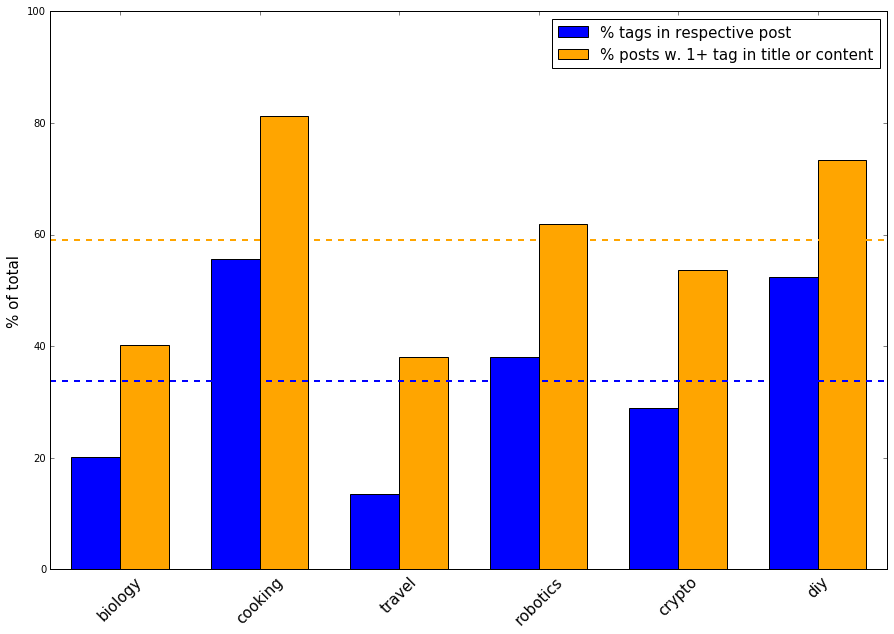

In [220]:
subjects = [subject for subject in all_tags_counter]
counts = pd.concat([pd.Series([(tags_in_post_counter[subject]/float(all_tags_counter[subject]))*100 \
                               for subject in subjects], index=subjects), 
                    pd.Series([(posts_with_tag[subject]/float(subjects_dfs[subject].shape[0]))*100 \
                               for subject in subjects], index=subjects)], axis=1)

inpost_vs_apps_string = "% tags in respective post"
posts_w_tags_string = "% posts w. 1+ tag in title or content"

counts.columns = [inpost_vs_apps_string, posts_w_tags_string]
index_dict = {}
for i, subject in enumerate(subjects):
    index_dict[i] = subject
    
print(counts, end="\n"*2)

cross_subject_inpost_vs_apps = \
        (cross_subject_tags_in_post_counter/float(cross_subject_all_tags_counter))*100
cross_subject_posts_w_tags = \
        (cross_subject_posts_with_tag/float(np.sum([subjects_dfs[subject].shape[0] for subject in subjects])))*100

print("mean values")
print("% tags in respective post" + "\t"*2, cross_subject_inpost_vs_apps)
print("% posts w. 1+ tag in title or content" + "\t", cross_subject_posts_w_tags)

# code below based on 
# http://emptypipes.org/2013/11/09/matplotlib-multicategory-barchart/
# http://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html
plt.close()

width = 0.35
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ind = np.arange(counts.shape[0])

rects1 = ax.bar(ind, counts[inpost_vs_apps_string], width, color='blue')
ax.axhline(y=cross_subject_inpost_vs_apps,c="blue", ls="dashed", linewidth=2)

rects2 = ax.bar(ind+width, counts[posts_w_tags_string], width, color='orange')
ax.axhline(y=cross_subject_posts_w_tags,c="orange", ls="dashed", linewidth=2)

ax.set_ylabel("% of total", fontsize=15)

xTickMarks = [subject for subject in all_tags_counter]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=15)

ax.legend((rects1[0], rects2[0]), (inpost_vs_apps_string, posts_w_tags_string), fontsize=15)

plt.axis([-0.15, 5.85, 0, 100])

plt.show()

## Conclusion

It seems that keyword extraction by merely discovering TFIDF terms in the data may be surprisingly insufficient when only ~1/3 tags applied appears in a post, and when just over half of all posts contain any of the tags they are assigned.

Perhaps this problem could use a more advanced approach where the tags applied do not depend on their appearance on the text, but rather on latent semantic features in the post or in the corpus. (Many Stack Exchange participants use tags to categorize their posts in context of the whole site, for instance.) [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis) could be used for its synonym-merging possibilities. Word embedding approaches could also prove useful if a method is devised to map potential terms or concepts corresponding to a document to a nearby term that is likely to be a tag. This could depend on knowledge of the tag space, which could be learnt through the training data. 

Having data on how a posts' tags change could be useful. Tags initially assigned to a post are many times tweaked, reassigned, deleted, or added later by more experienced users. Observing these events could be useful to figure out the mapping, however obscure, from post to stable tags.